In [ ]:
!pip install "jax[cuda12]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

In [1]:
import jax
import jax.numpy as jnp
from jax import random, grad, value_and_grad
import jax.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import gzip
import struct
from urllib import request
from tqdm import tqdm
from jax.tree_util import tree_map
import tarfile
import io

# Model Definition

In [2]:
class CNNConfig:
    def __init__(self):
        self.input_shape = (1, 32, 32, 3)  # (batch_size, height, width, channels) for CIFAR-10
        self.conv1_filters = 64
        self.conv2_filters = 128
        self.conv3_filters = 256
        self.kernel_size = 3
        self.dense_units = 512
        self.output_classes = 10

def conv2d(x, w, b, stride=1, padding='SAME'):
    """Convolutional layer implementation"""
    x = jax.lax.conv_general_dilated(
        lhs=x,
        rhs=w,
        window_strides=(stride, stride),
        padding=padding,
        dimension_numbers=('NHWC', 'OIHW', 'NHWC')
    )
    return x + b

def relu(x):
    """ReLU activation function"""
    return jnp.maximum(x, 0)

def max_pool(x, pool_size=2, stride=2, padding='VALID'):
    """Max pooling layer implementation"""
    return jax.lax.reduce_window(
        x,
        -jnp.inf,
        jax.lax.max,
        window_dimensions=(1, pool_size, pool_size, 1),
        window_strides=(1, stride, stride, 1),
        padding=padding
    )

def dense(x, w, b):
    """Fully connected layer implementation"""
    return jnp.dot(x, w) + b

def initialize_cnn_params(rng, config):
    """Initialize CNN model parameters with He initialization"""
    params = {}
    k1, k2, k3, k4, k5 = random.split(rng, 5)
    
    # Conv1 layer parameters
    params['conv1_w'] = random.normal(k1, (
        config.conv1_filters, config.input_shape[-1], 
        config.kernel_size, 
        config.kernel_size)
    ) * jnp.sqrt(2/(config.kernel_size**2 * config.input_shape[-1]))
    params['conv1_b'] = jnp.zeros((config.conv1_filters,))
    
    # Simulate forward pass to get output shape after conv1 + pool
    x = jnp.zeros(config.input_shape)
    x = conv2d(x, params['conv1_w'], params['conv1_b'])
    x = relu(x)
    x = max_pool(x)
    
    # Conv2 layer parameters
    params['conv2_w'] = random.normal(k2, (config.conv2_filters, config.conv1_filters, 
                                          config.kernel_size, config.kernel_size)) * jnp.sqrt(2/(config.kernel_size**2 * config.conv1_filters))
    params['conv2_b'] = jnp.zeros((config.conv2_filters,))
    
    # Simulate forward pass to get output shape after conv2 + pool
    x = conv2d(x, params['conv2_w'], params['conv2_b'])
    x = relu(x)
    x = max_pool(x)
    
    # Conv3 layer parameters
    params['conv3_w'] = random.normal(k3, (config.conv3_filters, config.conv2_filters, 
                                          config.kernel_size, config.kernel_size)) * jnp.sqrt(2/(config.kernel_size**2 * config.conv2_filters))
    params['conv3_b'] = jnp.zeros((config.conv3_filters,))
    
    # Simulate forward pass to get output shape after conv3 + pool
    x = conv2d(x, params['conv3_w'], params['conv3_b'])
    x = relu(x)
    x = max_pool(x)
    
    # Calculate flattened dimensions for dense layer
    flatten_dim = x.shape[1] * x.shape[2] * x.shape[3]
    
    # Dense layers parameters
    params['dense1_w'] = random.normal(k4, (flatten_dim, config.dense_units)) * jnp.sqrt(2/flatten_dim)
    params['dense1_b'] = jnp.zeros((config.dense_units,))
    
    params['dense2_w'] = random.normal(k5, (config.dense_units, config.output_classes)) * jnp.sqrt(2/config.dense_units)
    params['dense2_b'] = jnp.zeros((config.output_classes,))
    
    return params

    
def forward(params, x):
    """Forward pass through the CNN model"""
    # First conv block
    x = conv2d(x, params['conv1_w'], params['conv1_b'])
    x = relu(x)
    x = max_pool(x)
    
    # Second conv block
    x = conv2d(x, params['conv2_w'], params['conv2_b'])
    x = relu(x)
    x = max_pool(x)
    
    # Third conv block
    x = conv2d(x, params['conv3_w'], params['conv3_b'])
    x = relu(x)
    x = max_pool(x)
    
    # Flatten for dense layer
    x = x.reshape((x.shape[0], -1))
    
    # Dense layers
    x = dense(x, params['dense1_w'], params['dense1_b'])
    x = relu(x)
    x = dense(x, params['dense2_w'], params['dense2_b'])
    
    return x

# Optimizers

In [3]:
class SGDOptimizer:
    """Stochastic Gradient Descent optimizer implementation"""
    def __init__(self, learning_rate=0.01):
        self.learning_rate = learning_rate
    
    def init(self, params):
        """Initialize optimizer (no-op for SGD)"""
        # SGD doesn't need to maintain state
        pass
    
    def update(self, params, grads):
        """Update parameters using gradients"""
        return tree_map(lambda p, g: p - self.learning_rate * g, params, grads)

class AdamOptimizer:
    """Adam optimizer implementation (compatible with JAX transformations)"""
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
    
    def init(self, params):
        """Initialize optimizer state"""
        # Return optimizer state instead of storing it as instance variables
        return {
            'm': tree_map(jnp.zeros_like, params),
            'v': tree_map(jnp.zeros_like, params),
            't': 0
        }
    
    def update(self, params, grads, opt_state):
        """Update parameters using gradients and optimizer state"""
        # Unpack optimizer state
        m, v, t = opt_state['m'], opt_state['v'], opt_state['t']
        
        # Increment timestep
        t = t + 1
        
        # Update biased first moment estimate
        m = tree_map(
            lambda m_i, g_i: self.beta1 * m_i + (1 - self.beta1) * g_i, 
            m, grads
        )
        
        # Update biased second raw moment estimate
        v = tree_map(
            lambda v_i, g_i: self.beta2 * v_i + (1 - self.beta2) * (g_i * g_i), 
            v, grads
        )
        
        # Compute bias-corrected first moment estimate
        m_hat = tree_map(
            lambda m_i: m_i / (1 - self.beta1 ** t), 
            m
        )
        
        # Compute bias-corrected second raw moment estimate
        v_hat = tree_map(
            lambda v_i: v_i / (1 - self.beta2 ** t), 
            v
        )
        
        # Update parameters
        updated_params = tree_map(
            lambda p, m_h, v_h: p - self.learning_rate * m_h / (jnp.sqrt(v_h) + self.epsilon),
            params, m_hat, v_hat
        )
        
        # Return updated parameters and optimizer state
        updated_opt_state = {'m': m, 'v': v, 't': t}
        return updated_params, updated_opt_state

# Metrics

In [4]:
def cross_entropy_loss(params, batch_images, batch_labels):
    """
    Compute cross entropy loss for a batch of images
    
    Args:
        params: Model parameters
        batch_images: Batch of input images (shape: [batch_size, height, width, channels])
        batch_labels: Batch of labels (shape: [batch_size])
        
    Returns:
        Average cross entropy loss for the batch
    """
    # Get model predictions
    logits = forward(params, batch_images)
    
    # Compute log probabilities
    log_probs = nn.log_softmax(logits)
    
    # Convert labels to one-hot encoding
    one_hot = jax.nn.one_hot(batch_labels, 10)
    
    # Compute cross entropy loss (negative log likelihood)
    return -jnp.sum(one_hot * log_probs) / batch_images.shape[0]

def compute_accuracy(params, batch_images, batch_labels):
    """
    Compute accuracy for a batch of images
    
    Args:
        params: Model parameters
        batch_images: Batch of input images
        batch_labels: Batch of labels
        
    Returns:
        Accuracy as a value between 0 and 1
    """
    # Get model predictions
    logits = forward(params, batch_images)
    
    # Get predicted class indices
    preds = jnp.argmax(logits, axis=-1)
    
    # Compute accuracy
    return jnp.mean(preds == batch_labels)

def precision_recall_f1(params, batch_images, batch_labels):
    """
    Compute precision, recall, and F1 score for a batch of images
    
    Args:
        params: Model parameters
        batch_images: Batch of input images
        batch_labels: Batch of labels
        
    Returns:
        Tuple of (precision, recall, f1) averaged across all classes
    """
    # Get model predictions
    logits = forward(params, batch_images)
    preds = jnp.argmax(logits, axis=-1)
    
    # Number of classes (CIFAR-10 has 10 classes)
    num_classes = 10
    
    # Initialize lists for metrics
    precision_list, recall_list, f1_list = [], [], []
    
    # Compute metrics for each class
    for cls in range(num_classes):
        # True positives, false positives, false negatives
        tp = jnp.sum((preds == cls) & (batch_labels == cls))
        fp = jnp.sum((preds == cls) & (batch_labels != cls))
        fn = jnp.sum((preds != cls) & (batch_labels == cls))
        
        # Compute precision, recall, and F1 with small epsilon to avoid division by zero
        epsilon = 1e-8
        precision = tp / (tp + fp + epsilon)
        recall = tp / (tp + fn + epsilon)
        f1 = 2 * precision * recall / (precision + recall + epsilon)
        
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)
    
    # Return average metrics across all classes
    return jnp.mean(jnp.array(precision_list)), jnp.mean(jnp.array(recall_list)), jnp.mean(jnp.array(f1_list))


# Data Loading and Utilities

In [5]:
def download_cifar10(data_dir):
    """Download CIFAR-10 dataset if it doesn't exist"""
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    
    # URLs for CIFAR-10 dataset
    base_url = "https://www.cs.toronto.edu/~kriz/"
    train_file = "cifar-10-python.tar.gz"
    train_url = base_url + train_file
    train_path = os.path.join(data_dir, train_file)
    
    # Download the dataset if not already present
    if not os.path.exists(train_path):
        print(f"Downloading CIFAR-10 dataset from {train_url}...")
        request.urlretrieve(train_url, train_path)
        print("Download complete.")
    else:
        print("CIFAR-10 dataset already exists.")
    
    return train_path

def unpickle(file):
    """Unpickle CIFAR-10 batch files"""
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def load_cifar10_raw(data_dir):
    """
    Load CIFAR-10 dataset from raw files
    
    Returns:
        Tuple of (train_images, train_labels, test_images, test_labels)
    """
    # Download dataset if needed
    cifar_path = download_cifar10(data_dir)
    
    # Extract files if not already extracted
    cifar_dir = os.path.join(data_dir, "cifar-10-batches-py")
    if not os.path.exists(cifar_dir):
        print("Extracting CIFAR-10 files...")
        with tarfile.open(cifar_path, 'r:gz') as tar:
            tar.extractall(path=data_dir)
        print("Extraction complete.")
    
    # Load training data (batches 1-5)
    train_images = []
    train_labels = []
    for i in range(1, 6):
        batch_file = os.path.join(cifar_dir, f"data_batch_{i}")
        batch_data = unpickle(batch_file)
        train_images.append(batch_data[b'data'])
        train_labels.extend(batch_data[b'labels'])
    
    # Reshape training data
    train_images = np.vstack(train_images).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    train_labels = np.array(train_labels)


    # Load test data
    test_batch_file = os.path.join(cifar_dir, "test_batch")
    test_data = unpickle(test_batch_file)
    test_images = test_data[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    test_labels = np.array(test_data[b'labels'])
    
    return train_images, train_labels, test_images, test_labels


def create_batches(images, labels, batch_size, shuffle=True):
    """Create batches of data for training/evaluation"""
    num_examples = len(images)
    indices = np.arange(num_examples)
    
    if shuffle:
        np.random.shuffle(indices)
    
    # Create list of batches
    batches = []
    for start_idx in range(0, num_examples, batch_size):
        end_idx = min(start_idx + batch_size, num_examples)
        batch_indices = indices[start_idx:end_idx]
        batches.append((images[batch_indices], labels[batch_indices]))
    
    return batches

def load_cifar10(batch_size=128, seed=0):
    """
    Load and preprocess CIFAR-10 dataset
    
    Args:
        batch_size: Batch size for training/evaluation
        seed: Random seed for shuffling
        
    Returns:
        Tuple of (train_batches, test_batches)
    """
    # Set random seed for reproducibility
    np.random.seed(seed)
    
    # Check if preprocessed data exists in cache
    data_dir = "cifar10_data"
    cache_file = os.path.join(data_dir, "cifar10_preprocessed.pkl")
    if os.path.exists(cache_file):
        print("Loading preprocessed CIFAR-10 data from cache...")
        with open(cache_file, 'rb') as f:
            train_images, train_labels, test_images, test_labels = pickle.load(f)
    else:
        print("Loading CIFAR-10 from raw files...")
        # Load raw data
        train_images, train_labels, test_images, test_labels = load_cifar10_raw(data_dir)
        
        # Preprocess images: normalize to [0,1]
        train_images = train_images.astype(np.float32) / 255.0
        test_images = test_images.astype(np.float32) / 255.0
        
        # Cache the preprocessed data
        os.makedirs(data_dir, exist_ok=True)
        with open(cache_file, 'wb') as f:
            pickle.dump((train_images, train_labels, test_images, test_labels), f)
        print(f"Saved preprocessed data to {cache_file}")
    
    # Data augmentation (add later for improved performance)
    # For simplicity, we'll skip data augmentation in this implementation
    
    # Create training and test batches
    train_batches = create_batches(train_images, train_labels, batch_size, shuffle=True)
    test_batches = create_batches(test_images, test_labels, batch_size, shuffle=False)
    
    print(f"Created {len(train_batches)} training batches and {len(test_batches)} test batches")
    return train_batches, test_batches

def plot_training_curves(train_losses, test_losses, train_accuracies, test_accuracies):
    """Plot training and testing curves for loss and accuracy"""
    plt.figure(figsize=(10, 4))
    
    # Loss curve
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curve')
    
    # Accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Curve')
    
    plt.tight_layout()
    plt.savefig('cifar10_training_curves.png')
    plt.show()

def select_device(device_type="auto"):
    """
    Select appropriate device for training (CPU/GPU/TPU)
    
    Args:
        device_type: 'cpu', 'gpu', or 'auto' to automatically select
        
    Returns:
        Selected JAX device
    """
    if device_type == "cpu":
        device = jax.devices("cpu")[0]
    elif device_type == "gpu":
        try:
            gpus = jax.devices("gpu")
            if not gpus:
                raise RuntimeError("No GPU found, falling back to CPU")
            device = gpus[0]
        except RuntimeError:
            print("Warning: GPU requested but not available. Using CPU instead.")
            device = jax.devices("cpu")[0]
    else:  # Auto mode
        # Try to use GPU if available, otherwise use CPU
        try:
            gpus = jax.devices("gpu")
            if gpus:
                device = gpus[0]
                print("GPU detected, using GPU for training")
            else:
                device = jax.devices("cpu")[0]
                print("No GPU detected, using CPU for training")
        except:
            device = jax.devices("cpu")[0]
            print("Error detecting GPUs, falling back to CPU")
    
    print(f"✅ Using device: {device}")
    return device


# Training Functions

In [6]:
def save_model(params, path='best_cifar10_model.pkl'):
    """
    Save model parameters to a file
    
    Args:
        params: Model parameters to save
        path: File path to save to
    """
    # Create directory if it doesn't exist
    os.makedirs(os.path.dirname(path) if os.path.dirname(path) else '.', exist_ok=True)
    
    with open(path, 'wb') as f:
        pickle.dump(params, f)
    print(f"✅ Model saved at {path}")

def load_model(path='best_cifar10_model.pkl'):
    """
    Load model parameters from a file
    
    Args:
        path: File path to load from
        
    Returns:
        Loaded model parameters
    """
    if not os.path.exists(path):
        raise FileNotFoundError(f"Model file not found: {path}")
    
    with open(path, 'rb') as f:
        params = pickle.load(f)
    print(f"✅ Model loaded from {path}")
    return params

def get_learning_rate(initial_lr, epoch, decay_epochs=10, decay_factor=0.5):
    """
    Calculate learning rate with step decay
    
    Args:
        initial_lr: Initial learning rate
        epoch: Current epoch (1-based)
        decay_epochs: Number of epochs after which to decay the learning rate
        decay_factor: Factor by which to decay the learning rate
        
    Returns:
        Decayed learning rate
    """
    return initial_lr * (decay_factor ** (epoch // decay_epochs))

def evaluate(params, data_batches, device):
    """
    Evaluate model on a set of batches
    
    Args:
        params: Model parameters
        data_batches: List of (images, labels) batches
        device: JAX device to use for computation
        
    Returns:
        Dictionary of evaluation metrics
    """
    # Initialize metrics
    losses, accs, precs, recs, f1s = [], [], [], [], []
    
    # Evaluate on each batch
    for batch_images, batch_labels in data_batches:
        # Convert to JAX arrays and move to device
        batch_images = jax.device_put(jnp.array(batch_images), device)
        batch_labels = jax.device_put(jnp.array(batch_labels), device)
        
        # Compute metrics
        loss = cross_entropy_loss(params, batch_images, batch_labels)
        acc = compute_accuracy(params, batch_images, batch_labels)
        precision, recall, f1 = precision_recall_f1(params, batch_images, batch_labels)
        
        # Collect results
        losses.append(loss)
        accs.append(acc)
        precs.append(precision)
        recs.append(recall)
        f1s.append(f1)
    
    # Calculate average metrics
    return {
        'loss': jnp.mean(jnp.array(losses)),
        'accuracy': jnp.mean(jnp.array(accs)),
        'precision': jnp.mean(jnp.array(precs)),
        'recall': jnp.mean(jnp.array(recs)),
        'f1': jnp.mean(jnp.array(f1s)),
    }

# Main Training Function

In [7]:
def main():
    """Main training function"""
    print("\n=== CNN CIFAR-10 Classifier in JAX ===\n")
    
    # --- MODEL CONFIGURATION ---
    model_config = CNNConfig()
    
    # --- TRAINING HYPERPARAMETERS ---
    num_epochs = 50  # More epochs for CIFAR-10
    batch_size = 128
    initial_learning_rate = 0.001
    decay_epochs = 15  # Slower decay for CIFAR-10
    decay_factor = 0.5
    checkpoint_path = 'best_cifar10_model.pkl'
    seed = 42
    
    # --- DEVICE SETUP ---
    device = select_device("auto")
    
    # --- DATA LOADING ---
    print("\nLoading CIFAR-10 dataset...")
    train_batches, test_batches = load_cifar10(batch_size=batch_size, seed=seed)
    
    # --- MODEL INITIALIZATION ---
    print("\nInitializing model parameters...")
    rng = random.PRNGKey(seed)
    rng = jax.device_put(rng, device)
    params = initialize_cnn_params(rng, model_config)
    
    # --- OPTIMIZER SETUP ---
    print("Setting up Adam optimizer...")
    optimizer = AdamOptimizer(learning_rate=initial_learning_rate)
    opt_state = optimizer.init(params)
    
    # --- METRICS TRACKING ---
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []
    best_f1 = 0.0
    
    # --- UPDATE FUNCTION ---
    @jax.jit
    def update(params, batch_images, batch_labels, opt_state):
        """JIT-compiled update function for efficiency"""
        loss_value, grads = value_and_grad(cross_entropy_loss)(params, batch_images, batch_labels)
        updated_params, updated_opt_state = optimizer.update(params, grads, opt_state)
        return updated_params, updated_opt_state, loss_value
    
    # --- TRAINING LOOP ---
    print("\nStarting training...\n")
    for epoch in range(1, num_epochs + 1):
        epoch_losses = []
        
        # Update learning rate with decay
        current_lr = get_learning_rate(initial_learning_rate, epoch, decay_epochs, decay_factor)
        optimizer.learning_rate = current_lr
        
        print(f"Epoch {epoch}/{num_epochs} - Learning Rate: {current_lr:.6f}")
        
        # Training phase
        for batch_idx, (batch_images, batch_labels) in enumerate(tqdm(train_batches, desc="Training")):
            # Convert to JAX arrays and put on device
            batch_images_jax = jax.device_put(jnp.array(batch_images), device)
            batch_labels_jax = jax.device_put(jnp.array(batch_labels), device)
            
            # Update parameters and optimizer state
            params, opt_state, loss = update(params, batch_images_jax, batch_labels_jax, opt_state)
            epoch_losses.append(loss)
        
        # Calculate average training loss for the epoch
        train_loss = jnp.mean(jnp.array(epoch_losses))
        train_losses.append(train_loss)
        
        # Evaluate on training set (using subset for efficiency)
        print("Evaluating on training set...")
        train_eval_batches = train_batches[:len(train_batches)//10]  # Use 10% of training data for evaluation
        train_metrics = evaluate(params, train_eval_batches, device)
        train_accuracy = train_metrics['accuracy']
        train_accuracies.append(train_accuracy)
        
        # Evaluate on test set
        print("Evaluating on test set...")
        test_metrics = evaluate(params, test_batches, device)
        test_losses.append(test_metrics['loss'])
        test_accuracies.append(test_metrics['accuracy'])
        
        # Save model if improved
        if test_metrics['f1'] > best_f1:
            best_f1 = test_metrics['f1']
            save_model(params, checkpoint_path)
            print(f"✅ New best model saved (F1: {best_f1:.4f})")
        
        # Print epoch summary
        print(f"Epoch {epoch:02d} Summary:")
        print(f"  Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"  Test Loss: {test_metrics['loss']:.4f}, Test Accuracy: {test_metrics['accuracy']:.4f}")
        print(f"  Test Precision: {test_metrics['precision']:.4f}, Test Recall: {test_metrics['recall']:.4f}, Test F1: {test_metrics['f1']:.4f}")
        print()
    
    # --- PLOT TRAINING CURVES ---
    print("\nPlotting training curves...")
    plot_training_curves(train_losses, test_losses, train_accuracies, test_accuracies)
    
    # --- FINAL EVALUATION ---
    print("\nLoading best model for final evaluation...")
    best_params = load_model(checkpoint_path)
    final_metrics = evaluate(best_params, test_batches, device)
    
    print("\n🏆 FINAL EVALUATION (Best Model):")
    print(f"  Test Loss: {final_metrics['loss']:.4f}")
    print(f"  Test Accuracy: {final_metrics['accuracy']:.4f}")
    print(f"  Test Precision: {final_metrics['precision']:.4f}")
    print(f"  Test Recall: {final_metrics['recall']:.4f}")
    print(f"  Test F1: {final_metrics['f1']:.4f}")



=== CNN CIFAR-10 Classifier in JAX ===

GPU detected, using GPU for training
✅ Using device: cuda:0

Loading CIFAR-10 dataset...
Loading preprocessed CIFAR-10 data from cache...
Created 391 training batches and 79 test batches

Initializing model parameters...
Setting up Adam optimizer...

Starting training...

Epoch 1/50 - Learning Rate: 0.001000


Training: 100%|██████████| 391/391 [00:44<00:00,  8.73it/s]


Evaluating on training set...
Evaluating on test set...
✅ Model saved at best_cifar10_model.pkl
✅ New best model saved (F1: 0.6025)
Epoch 01 Summary:
  Train Loss: 1.5214, Train Accuracy: 0.6138
  Test Loss: 1.0870, Test Accuracy: 0.6203
  Test Precision: 0.6140, Test Recall: 0.6147, Test F1: 0.6025

Epoch 2/50 - Learning Rate: 0.001000


Training: 100%|██████████| 391/391 [00:00<00:00, 540.66it/s]


Evaluating on training set...
Evaluating on test set...
✅ Model saved at best_cifar10_model.pkl
✅ New best model saved (F1: 0.6391)
Epoch 02 Summary:
  Train Loss: 0.9944, Train Accuracy: 0.6707
  Test Loss: 0.9743, Test Accuracy: 0.6607
  Test Precision: 0.6599, Test Recall: 0.6550, Test F1: 0.6391

Epoch 3/50 - Learning Rate: 0.001000


Training: 100%|██████████| 391/391 [00:00<00:00, 564.69it/s]


Evaluating on training set...
Evaluating on test set...
✅ Model saved at best_cifar10_model.pkl
✅ New best model saved (F1: 0.6573)
Epoch 03 Summary:
  Train Loss: 0.8040, Train Accuracy: 0.7129
  Test Loss: 0.9427, Test Accuracy: 0.6760
  Test Precision: 0.6809, Test Recall: 0.6711, Test F1: 0.6573

Epoch 4/50 - Learning Rate: 0.001000


Training: 100%|██████████| 391/391 [00:00<00:00, 537.89it/s]


Evaluating on training set...
Evaluating on test set...
✅ Model saved at best_cifar10_model.pkl
✅ New best model saved (F1: 0.6933)
Epoch 04 Summary:
  Train Loss: 0.6682, Train Accuracy: 0.7666
  Test Loss: 0.8721, Test Accuracy: 0.7052
  Test Precision: 0.7136, Test Recall: 0.7005, Test F1: 0.6933

Epoch 5/50 - Learning Rate: 0.001000


Training: 100%|██████████| 391/391 [00:00<00:00, 567.93it/s]


Evaluating on training set...
Evaluating on test set...
✅ Model saved at best_cifar10_model.pkl
✅ New best model saved (F1: 0.7023)
Epoch 05 Summary:
  Train Loss: 0.5547, Train Accuracy: 0.8153
  Test Loss: 0.8644, Test Accuracy: 0.7175
  Test Precision: 0.7183, Test Recall: 0.7113, Test F1: 0.7023

Epoch 6/50 - Learning Rate: 0.001000


Training: 100%|██████████| 391/391 [00:00<00:00, 617.08it/s]


Evaluating on training set...
Evaluating on test set...
✅ Model saved at best_cifar10_model.pkl
✅ New best model saved (F1: 0.7058)
Epoch 06 Summary:
  Train Loss: 0.4604, Train Accuracy: 0.8307
  Test Loss: 0.9245, Test Accuracy: 0.7211
  Test Precision: 0.7249, Test Recall: 0.7152, Test F1: 0.7058

Epoch 7/50 - Learning Rate: 0.001000


Training: 100%|██████████| 391/391 [00:00<00:00, 585.08it/s]


Evaluating on training set...
Evaluating on test set...
Epoch 07 Summary:
  Train Loss: 0.4009, Train Accuracy: 0.8317
  Test Loss: 1.0223, Test Accuracy: 0.7151
  Test Precision: 0.7223, Test Recall: 0.7082, Test F1: 0.7006

Epoch 8/50 - Learning Rate: 0.001000


Training: 100%|██████████| 391/391 [00:00<00:00, 640.77it/s]


Evaluating on training set...
Evaluating on test set...
✅ Model saved at best_cifar10_model.pkl
✅ New best model saved (F1: 0.7068)
Epoch 08 Summary:
  Train Loss: 0.3340, Train Accuracy: 0.8600
  Test Loss: 1.1049, Test Accuracy: 0.7159
  Test Precision: 0.7325, Test Recall: 0.7103, Test F1: 0.7068

Epoch 9/50 - Learning Rate: 0.001000


Training: 100%|██████████| 391/391 [00:00<00:00, 639.86it/s]


Evaluating on training set...
Evaluating on test set...
Epoch 09 Summary:
  Train Loss: 0.2751, Train Accuracy: 0.8832
  Test Loss: 1.1645, Test Accuracy: 0.7122
  Test Precision: 0.7205, Test Recall: 0.7079, Test F1: 0.7013

Epoch 10/50 - Learning Rate: 0.001000


Training: 100%|██████████| 391/391 [00:00<00:00, 645.94it/s]


Evaluating on training set...
Evaluating on test set...
Epoch 10 Summary:
  Train Loss: 0.2140, Train Accuracy: 0.8804
  Test Loss: 1.3622, Test Accuracy: 0.6898
  Test Precision: 0.7153, Test Recall: 0.6850, Test F1: 0.6827

Epoch 11/50 - Learning Rate: 0.001000


Training: 100%|██████████| 391/391 [00:00<00:00, 640.65it/s]


Evaluating on training set...
Evaluating on test set...
Epoch 11 Summary:
  Train Loss: 0.1962, Train Accuracy: 0.9175
  Test Loss: 1.3436, Test Accuracy: 0.7130
  Test Precision: 0.7354, Test Recall: 0.7060, Test F1: 0.7033

Epoch 12/50 - Learning Rate: 0.001000


Training: 100%|██████████| 391/391 [00:00<00:00, 640.63it/s]


Evaluating on training set...
Evaluating on test set...
✅ Model saved at best_cifar10_model.pkl
✅ New best model saved (F1: 0.7083)
Epoch 12 Summary:
  Train Loss: 0.1635, Train Accuracy: 0.9379
  Test Loss: 1.4235, Test Accuracy: 0.7223
  Test Precision: 0.7264, Test Recall: 0.7177, Test F1: 0.7083

Epoch 13/50 - Learning Rate: 0.001000


Training: 100%|██████████| 391/391 [00:00<00:00, 644.99it/s]


Evaluating on training set...
Evaluating on test set...
✅ Model saved at best_cifar10_model.pkl
✅ New best model saved (F1: 0.7130)
Epoch 13 Summary:
  Train Loss: 0.1269, Train Accuracy: 0.9395
  Test Loss: 1.4907, Test Accuracy: 0.7294
  Test Precision: 0.7291, Test Recall: 0.7252, Test F1: 0.7130

Epoch 14/50 - Learning Rate: 0.001000


Training: 100%|██████████| 391/391 [00:00<00:00, 644.87it/s]


Evaluating on training set...
Evaluating on test set...
Epoch 14 Summary:
  Train Loss: 0.1012, Train Accuracy: 0.9503
  Test Loss: 1.5364, Test Accuracy: 0.7263
  Test Precision: 0.7233, Test Recall: 0.7212, Test F1: 0.7102

Epoch 15/50 - Learning Rate: 0.000500


Training: 100%|██████████| 391/391 [00:00<00:00, 640.88it/s]


Evaluating on training set...
Evaluating on test set...
✅ Model saved at best_cifar10_model.pkl
✅ New best model saved (F1: 0.7157)
Epoch 15 Summary:
  Train Loss: 0.0876, Train Accuracy: 0.9529
  Test Loss: 1.5954, Test Accuracy: 0.7285
  Test Precision: 0.7323, Test Recall: 0.7226, Test F1: 0.7157

Epoch 16/50 - Learning Rate: 0.000500


Training: 100%|██████████| 391/391 [00:00<00:00, 639.54it/s]


Evaluating on training set...
Evaluating on test set...
Epoch 16 Summary:
  Train Loss: 0.0860, Train Accuracy: 0.9613
  Test Loss: 1.6502, Test Accuracy: 0.7169
  Test Precision: 0.7246, Test Recall: 0.7123, Test F1: 0.7071

Epoch 17/50 - Learning Rate: 0.000500


Training: 100%|██████████| 391/391 [00:00<00:00, 647.08it/s]


Evaluating on training set...
Evaluating on test set...
Epoch 17 Summary:
  Train Loss: 0.0889, Train Accuracy: 0.9589
  Test Loss: 1.7122, Test Accuracy: 0.7172
  Test Precision: 0.7235, Test Recall: 0.7123, Test F1: 0.7046

Epoch 18/50 - Learning Rate: 0.000500


Training: 100%|██████████| 391/391 [00:00<00:00, 615.59it/s]


Evaluating on training set...
Evaluating on test set...
Epoch 18 Summary:
  Train Loss: 0.0841, Train Accuracy: 0.9583
  Test Loss: 1.7081, Test Accuracy: 0.7168
  Test Precision: 0.7282, Test Recall: 0.7104, Test F1: 0.7066

Epoch 19/50 - Learning Rate: 0.000500


Training: 100%|██████████| 391/391 [00:00<00:00, 633.60it/s]


Evaluating on training set...
Evaluating on test set...
✅ Model saved at best_cifar10_model.pkl
✅ New best model saved (F1: 0.7166)
Epoch 19 Summary:
  Train Loss: 0.0680, Train Accuracy: 0.9643
  Test Loss: 1.6726, Test Accuracy: 0.7299
  Test Precision: 0.7280, Test Recall: 0.7248, Test F1: 0.7166

Epoch 20/50 - Learning Rate: 0.000500


Training: 100%|██████████| 391/391 [00:00<00:00, 609.83it/s]


Evaluating on training set...
Evaluating on test set...
Epoch 20 Summary:
  Train Loss: 0.0670, Train Accuracy: 0.9677
  Test Loss: 1.7161, Test Accuracy: 0.7203
  Test Precision: 0.7188, Test Recall: 0.7163, Test F1: 0.7073

Epoch 21/50 - Learning Rate: 0.000500


Training: 100%|██████████| 391/391 [00:00<00:00, 631.52it/s]


Evaluating on training set...
Evaluating on test set...
✅ Model saved at best_cifar10_model.pkl
✅ New best model saved (F1: 0.7170)
Epoch 21 Summary:
  Train Loss: 0.0627, Train Accuracy: 0.9762
  Test Loss: 1.7262, Test Accuracy: 0.7283
  Test Precision: 0.7291, Test Recall: 0.7233, Test F1: 0.7170

Epoch 22/50 - Learning Rate: 0.000500


Training: 100%|██████████| 391/391 [00:00<00:00, 632.32it/s]


Evaluating on training set...
Evaluating on test set...
Epoch 22 Summary:
  Train Loss: 0.0503, Train Accuracy: 0.9720
  Test Loss: 1.8595, Test Accuracy: 0.7259
  Test Precision: 0.7300, Test Recall: 0.7217, Test F1: 0.7155

Epoch 23/50 - Learning Rate: 0.000500


Training: 100%|██████████| 391/391 [00:00<00:00, 633.94it/s]


Evaluating on training set...
Evaluating on test set...
Epoch 23 Summary:
  Train Loss: 0.0500, Train Accuracy: 0.9720
  Test Loss: 2.0101, Test Accuracy: 0.7250
  Test Precision: 0.7254, Test Recall: 0.7210, Test F1: 0.7135

Epoch 24/50 - Learning Rate: 0.000500


Training: 100%|██████████| 391/391 [00:00<00:00, 647.48it/s]


Evaluating on training set...
Evaluating on test set...
Epoch 24 Summary:
  Train Loss: 0.0556, Train Accuracy: 0.9681
  Test Loss: 1.9547, Test Accuracy: 0.7251
  Test Precision: 0.7272, Test Recall: 0.7208, Test F1: 0.7153

Epoch 25/50 - Learning Rate: 0.000500


Training: 100%|██████████| 391/391 [00:00<00:00, 633.76it/s]


Evaluating on training set...
Evaluating on test set...
Epoch 25 Summary:
  Train Loss: 0.0532, Train Accuracy: 0.9702
  Test Loss: 1.9616, Test Accuracy: 0.7273
  Test Precision: 0.7259, Test Recall: 0.7232, Test F1: 0.7152

Epoch 26/50 - Learning Rate: 0.000500


Training: 100%|██████████| 391/391 [00:00<00:00, 650.08it/s]


Evaluating on training set...
Evaluating on test set...
Epoch 26 Summary:
  Train Loss: 0.0496, Train Accuracy: 0.9712
  Test Loss: 2.0185, Test Accuracy: 0.7266
  Test Precision: 0.7320, Test Recall: 0.7216, Test F1: 0.7164

Epoch 27/50 - Learning Rate: 0.000500


Training: 100%|██████████| 391/391 [00:00<00:00, 637.55it/s]


Evaluating on training set...
Evaluating on test set...
Epoch 27 Summary:
  Train Loss: 0.0488, Train Accuracy: 0.9728
  Test Loss: 2.0750, Test Accuracy: 0.7259
  Test Precision: 0.7242, Test Recall: 0.7221, Test F1: 0.7138

Epoch 28/50 - Learning Rate: 0.000500


Training: 100%|██████████| 391/391 [00:00<00:00, 638.17it/s]


Evaluating on training set...
Evaluating on test set...
✅ Model saved at best_cifar10_model.pkl
✅ New best model saved (F1: 0.7207)
Epoch 28 Summary:
  Train Loss: 0.0443, Train Accuracy: 0.9786
  Test Loss: 2.1260, Test Accuracy: 0.7323
  Test Precision: 0.7316, Test Recall: 0.7266, Test F1: 0.7207

Epoch 29/50 - Learning Rate: 0.000500


Training: 100%|██████████| 391/391 [00:00<00:00, 651.18it/s]


Evaluating on training set...
Evaluating on test set...
✅ Model saved at best_cifar10_model.pkl
✅ New best model saved (F1: 0.7260)
Epoch 29 Summary:
  Train Loss: 0.0449, Train Accuracy: 0.9882
  Test Loss: 2.1209, Test Accuracy: 0.7388
  Test Precision: 0.7334, Test Recall: 0.7343, Test F1: 0.7260

Epoch 30/50 - Learning Rate: 0.000250


Training: 100%|██████████| 391/391 [00:00<00:00, 647.50it/s]


Evaluating on training set...
Evaluating on test set...
Epoch 30 Summary:
  Train Loss: 0.0463, Train Accuracy: 0.9788
  Test Loss: 2.1276, Test Accuracy: 0.7256
  Test Precision: 0.7243, Test Recall: 0.7224, Test F1: 0.7123

Epoch 31/50 - Learning Rate: 0.000250


Training: 100%|██████████| 391/391 [00:00<00:00, 644.71it/s]


Evaluating on training set...
Evaluating on test set...
Epoch 31 Summary:
  Train Loss: 0.0419, Train Accuracy: 0.9820
  Test Loss: 2.2639, Test Accuracy: 0.7303
  Test Precision: 0.7291, Test Recall: 0.7248, Test F1: 0.7170

Epoch 32/50 - Learning Rate: 0.000250


Training: 100%|██████████| 391/391 [00:00<00:00, 645.24it/s]


Evaluating on training set...
Evaluating on test set...
Epoch 32 Summary:
  Train Loss: 0.0420, Train Accuracy: 0.9858
  Test Loss: 2.1611, Test Accuracy: 0.7311
  Test Precision: 0.7300, Test Recall: 0.7257, Test F1: 0.7199

Epoch 33/50 - Learning Rate: 0.000250


Training: 100%|██████████| 391/391 [00:00<00:00, 642.77it/s]


Evaluating on training set...
Evaluating on test set...
Epoch 33 Summary:
  Train Loss: 0.0377, Train Accuracy: 0.9828
  Test Loss: 2.1922, Test Accuracy: 0.7337
  Test Precision: 0.7300, Test Recall: 0.7291, Test F1: 0.7202

Epoch 34/50 - Learning Rate: 0.000250


Training: 100%|██████████| 391/391 [00:00<00:00, 603.97it/s]


Evaluating on training set...
Evaluating on test set...
Epoch 34 Summary:
  Train Loss: 0.0406, Train Accuracy: 0.9754
  Test Loss: 2.3459, Test Accuracy: 0.7283
  Test Precision: 0.7228, Test Recall: 0.7226, Test F1: 0.7107

Epoch 35/50 - Learning Rate: 0.000250


Training: 100%|██████████| 391/391 [00:00<00:00, 649.32it/s]


Evaluating on training set...
Evaluating on test set...
Epoch 35 Summary:
  Train Loss: 0.0397, Train Accuracy: 0.9844
  Test Loss: 2.2643, Test Accuracy: 0.7334
  Test Precision: 0.7315, Test Recall: 0.7291, Test F1: 0.7218

Epoch 36/50 - Learning Rate: 0.000250


Training: 100%|██████████| 391/391 [00:00<00:00, 621.85it/s]


Evaluating on training set...
Evaluating on test set...
Epoch 36 Summary:
  Train Loss: 0.0424, Train Accuracy: 0.9854
  Test Loss: 2.3275, Test Accuracy: 0.7283
  Test Precision: 0.7270, Test Recall: 0.7241, Test F1: 0.7166

Epoch 37/50 - Learning Rate: 0.000250


Training: 100%|██████████| 391/391 [00:00<00:00, 642.97it/s]


Evaluating on training set...
Evaluating on test set...
Epoch 37 Summary:
  Train Loss: 0.0465, Train Accuracy: 0.9792
  Test Loss: 2.3858, Test Accuracy: 0.7202
  Test Precision: 0.7193, Test Recall: 0.7138, Test F1: 0.7052

Epoch 38/50 - Learning Rate: 0.000250


Training: 100%|██████████| 391/391 [00:00<00:00, 615.78it/s]


Evaluating on training set...
Evaluating on test set...
Epoch 38 Summary:
  Train Loss: 0.0372, Train Accuracy: 0.9884
  Test Loss: 2.2918, Test Accuracy: 0.7359
  Test Precision: 0.7357, Test Recall: 0.7317, Test F1: 0.7249

Epoch 39/50 - Learning Rate: 0.000250


Training: 100%|██████████| 391/391 [00:00<00:00, 643.07it/s]


Evaluating on training set...
Evaluating on test set...
Epoch 39 Summary:
  Train Loss: 0.0326, Train Accuracy: 0.9858
  Test Loss: 2.5619, Test Accuracy: 0.7233
  Test Precision: 0.7228, Test Recall: 0.7173, Test F1: 0.7106

Epoch 40/50 - Learning Rate: 0.000250


Training: 100%|██████████| 391/391 [00:00<00:00, 619.70it/s]


Evaluating on training set...
Evaluating on test set...
Epoch 40 Summary:
  Train Loss: 0.0327, Train Accuracy: 0.9834
  Test Loss: 2.4532, Test Accuracy: 0.7272
  Test Precision: 0.7292, Test Recall: 0.7226, Test F1: 0.7171

Epoch 41/50 - Learning Rate: 0.000250


Training: 100%|██████████| 391/391 [00:00<00:00, 647.07it/s]


Evaluating on training set...
Evaluating on test set...
Epoch 41 Summary:
  Train Loss: 0.0321, Train Accuracy: 0.9890
  Test Loss: 2.5360, Test Accuracy: 0.7315
  Test Precision: 0.7297, Test Recall: 0.7270, Test F1: 0.7199

Epoch 42/50 - Learning Rate: 0.000250


Training: 100%|██████████| 391/391 [00:00<00:00, 621.49it/s]


Evaluating on training set...
Evaluating on test set...
Epoch 42 Summary:
  Train Loss: 0.0337, Train Accuracy: 0.9906
  Test Loss: 2.4496, Test Accuracy: 0.7309
  Test Precision: 0.7264, Test Recall: 0.7255, Test F1: 0.7170

Epoch 43/50 - Learning Rate: 0.000250


Training: 100%|██████████| 391/391 [00:00<00:00, 606.57it/s]


Evaluating on training set...
Evaluating on test set...
Epoch 43 Summary:
  Train Loss: 0.0383, Train Accuracy: 0.9882
  Test Loss: 2.5235, Test Accuracy: 0.7332
  Test Precision: 0.7291, Test Recall: 0.7299, Test F1: 0.7200

Epoch 44/50 - Learning Rate: 0.000250


Training: 100%|██████████| 391/391 [00:00<00:00, 622.86it/s]


Evaluating on training set...
Evaluating on test set...
Epoch 44 Summary:
  Train Loss: 0.0350, Train Accuracy: 0.9906
  Test Loss: 2.5129, Test Accuracy: 0.7337
  Test Precision: 0.7333, Test Recall: 0.7299, Test F1: 0.7224

Epoch 45/50 - Learning Rate: 0.000125


Training: 100%|██████████| 391/391 [00:00<00:00, 635.74it/s]


Evaluating on training set...
Evaluating on test set...
✅ Model saved at best_cifar10_model.pkl
✅ New best model saved (F1: 0.7265)
Epoch 45 Summary:
  Train Loss: 0.0376, Train Accuracy: 0.9898
  Test Loss: 2.3795, Test Accuracy: 0.7382
  Test Precision: 0.7359, Test Recall: 0.7335, Test F1: 0.7265

Epoch 46/50 - Learning Rate: 0.000125


Training: 100%|██████████| 391/391 [00:00<00:00, 579.41it/s]


Evaluating on training set...
Evaluating on test set...
Epoch 46 Summary:
  Train Loss: 0.0379, Train Accuracy: 0.9890
  Test Loss: 2.5093, Test Accuracy: 0.7337
  Test Precision: 0.7343, Test Recall: 0.7272, Test F1: 0.7211

Epoch 47/50 - Learning Rate: 0.000125


Training: 100%|██████████| 391/391 [00:00<00:00, 651.34it/s]


Evaluating on training set...
Evaluating on test set...
Epoch 47 Summary:
  Train Loss: 0.0290, Train Accuracy: 0.9882
  Test Loss: 2.6032, Test Accuracy: 0.7314
  Test Precision: 0.7323, Test Recall: 0.7270, Test F1: 0.7212

Epoch 48/50 - Learning Rate: 0.000125


Training: 100%|██████████| 391/391 [00:00<00:00, 617.16it/s]


Evaluating on training set...
Evaluating on test set...
Epoch 48 Summary:
  Train Loss: 0.0311, Train Accuracy: 0.9874
  Test Loss: 2.7014, Test Accuracy: 0.7193
  Test Precision: 0.7262, Test Recall: 0.7145, Test F1: 0.7102

Epoch 49/50 - Learning Rate: 0.000125


Training: 100%|██████████| 391/391 [00:00<00:00, 633.65it/s]


Evaluating on training set...
Evaluating on test set...
Epoch 49 Summary:
  Train Loss: 0.0341, Train Accuracy: 0.9922
  Test Loss: 2.5340, Test Accuracy: 0.7369
  Test Precision: 0.7345, Test Recall: 0.7330, Test F1: 0.7254

Epoch 50/50 - Learning Rate: 0.000125


Training: 100%|██████████| 391/391 [00:00<00:00, 618.80it/s]


Evaluating on training set...
Evaluating on test set...
Epoch 50 Summary:
  Train Loss: 0.0316, Train Accuracy: 0.9850
  Test Loss: 2.6564, Test Accuracy: 0.7296
  Test Precision: 0.7242, Test Recall: 0.7229, Test F1: 0.7142


Plotting training curves...


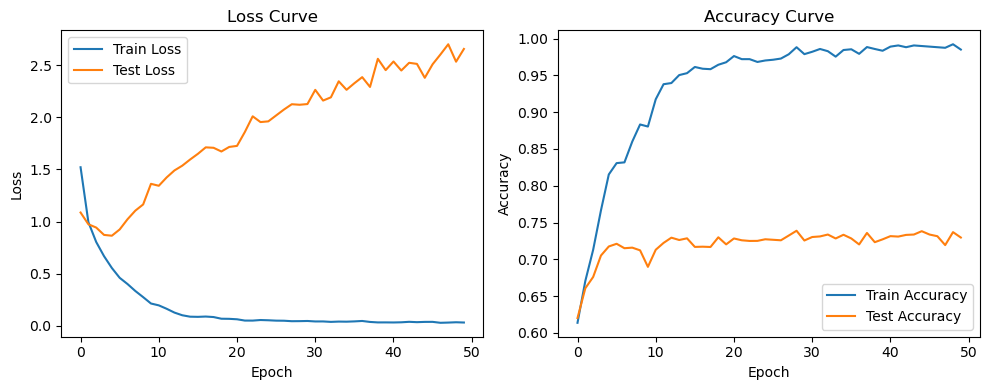


Loading best model for final evaluation...
✅ Model loaded from best_cifar10_model.pkl

🏆 FINAL EVALUATION (Best Model):
  Test Loss: 2.3795
  Test Accuracy: 0.7382
  Test Precision: 0.7359
  Test Recall: 0.7335
  Test F1: 0.7265


In [8]:
main()